# Model Cars Company

# Index

- [1 Introduction](#1)
- [2 Reading the Data](#2)
- [3 And Your Question is..?](#3)
- [4 Supply and Profit](#4)
- [5 Customer Loyalty](#5)
- [6 Show Me the Money... By Country!!](#6)
- [7 Most Sought After..](#7)
- [8 Monthly Profits Performance...](#8)
- [9 Closing the Deal..](#9)
- [10 Put that Money to Work..](#10)
- [11 Deadstock](#11)
- [12 Recommendations](#12)
- [13 Conclusions](#13)
- [14 Learnings](#14)

# 1

## Introduction

![image](https://mycustomhotwheels.com/wp-content/uploads/2019/01/HIN-Hot-Wheels-Diorama-15-1080x675.jpg)
*Source*:[mycustomhotwheels](https://mycustomhotwheels.com/hotwheels-at-hin2018/)

Vehicle Models Company is a fictitious wholesale distributor of die cast models of vehicles ranging from vintage cars to planes. They have customers in more than 15 countries around the world. 

The company has asked us to go over their dataset and analyse the same to make some essential decisions related to potential future expansion.

The goal of this project is to go over the questions that they have and extract answers based on the data.

It must be noted that the organization has given us freedom in taking assumptions as they do not have staff that can cater to our doubts and questions. We have been advised that clarification (regarding our assumptions) will be made after an initial report has been submitted.

# 2

## Reading the Data

The required data is available [here](https://www.mysqltutorial.org/mysql-sample-database.aspx) along with the schema which has been provided below.

In [2]:
%%capture
%load_ext sql
%sql sqlite:///stores.db

![image](https://www.mysqltutorial.org/wp-content/uploads/2009/12/MySQL-Sample-Database-Schema.png)

Before we proceed with analysing the database, let's look at an overview of it.

In [3]:
%%sql
SELECT '' AS Table_Names,'' AS Number_of_Attributes,'' AS Number_of_Rows
UNION ALL
SELECT 'Customer',13,(SELECT COUNT(*)
                        FROM customers)
UNION ALL
SELECT 'Products',9,(SELECT COUNT(*)
                        FROM products)
UNION ALL
SELECT 'ProductLines',4,(SELECT COUNT(*)
                        FROM productlines)
UNION ALL
SELECT 'Orders',7,(SELECT COUNT(*)
                        FROM orders)
UNION ALL
SELECT 'OrderDetails',5,(SELECT COUNT(*)
                        FROM orderdetails)
UNION ALL
SELECT 'Payments',4,(SELECT COUNT(*)
                        FROM payments)
UNION ALL
SELECT 'Employees',8,(SELECT COUNT(*)
                        FROM employees)
UNION ALL
SELECT 'Offices',9,(SELECT COUNT(*)
                        FROM offices)

 * sqlite:///stores.db
Done.


Table_Names,Number_of_Attributes,Number_of_Rows
,,
Customer,13,122
Products,9,110
ProductLines,4,7
Orders,7,326
OrderDetails,5,2996
Payments,4,273
Employees,8,23
Offices,9,7


Also, let's look at a description of each table:

- Customers: stores customer’s data.
- Products: stores a list of scale model cars.
- ProductLines: stores a list of product line categories.
- Orders: stores sales orders placed by customers.
- OrderDetails: stores sales order line items for each sales order.
- Payments: stores payments made by customers based on their accounts.
- Employees: stores all employee information as well as the organization structure such as who reports to whom.
- Offices: stores sales office data.

Now, let's turn to the offices table. We are going to read the following SQL query into a DataFrame.

In [4]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('stores.db')
df = pd.read_sql_query("""SELECT * 
                            FROM offices;""", conn)
df

,officeCode,city,phone,addressLine1,addressLine2,state,country,postalCode,territory
0,1,San Francisco,+1 650 219 4782,100 Market Street,Suite 300,CA,USA,94080,NA
1,2,Boston,+1 215 837 0825,1550 Court Place,Suite 102,MA,USA,02107,NA
2,3,NYC,+1 212 555 3000,523 East 53rd Street,apt. 5A,NY,USA,10022,NA
3,4,Paris,+33 14 723 4404,43 Rue Jouffroy D'abbans,None,None,France,75017,EMEA
4,5,Tokyo,+81 33 224 5000,4-1 Kioicho,None,Chiyoda-Ku,Japan,102-8578,Japan
5,6,Sydney,+61 2 9264 2451,5-11 Wentworth Avenue,Floor #2,None,Australia,NSW 2010,APAC
6,7,London,+44 20 7877 2041,25 Old Broad Street,Level 7,None,UK,EC2N 1HN,EMEA


The company has a number of offices and each office has multiple employees. Every customer is associated to a sales rep. whose employee ID is recorded in the salesRepEmployeeNumber column of the Customer table.

The company has many products that are categorised into product lines. Every incoming order lists certain order specific details related to a product and those details are listed in the OrderDetails table. The orders associated to the items in the OrderDetails table are separately tracked in the Orders table. 

The status column in the order tracks the progress of the order from when it is received to when it is shipped out. The different statuses of an order have been listed below.

Once the order is shipped out, customers seem to be paying for their orders in a cumulative manner. Customers have the option of utilising credit based on the CreditLimit column the in the Customer table. While going over the comments column of the Orders table it was noticed that an order can be put on hold if a user has gone beyond their credit limit for a particular order. The order is processed only after the payment is cleared.

In [5]:
%%sql
SELECT status AS Order_Status,COUNT(status) AS Number_of_Orders
  FROM orders
 GROUP BY status
 ORDER BY Number_of_Orders DESC

 * sqlite:///stores.db
Done.


Order_Status,Number_of_Orders
Shipped,303
In Process,6
Cancelled,6
Resolved,4
On Hold,4
Disputed,3


We shall be analyzing only orders that have shipped out since all of the other orders require payment clearance. Orders and Order Details associated to shipped orders will therefore need to be filtered out.

In [6]:
%%sql
--#Create view to filter only orders with status 'Shipped'
CREATE VIEW shipped_orders AS
SELECT orders.*,
       ROUND(SUM(orderdetails.quantityOrdered*orderdetails.priceEach),2) AS Order_Total,
       ROUND(SUM((orderdetails.priceEach - products.buyPrice)*orderdetails.quantityOrdered),2) AS Order_Profit
  FROM orders
  JOIN orderdetails
    ON orders.orderNumber=orderdetails.orderNumber
  JOIN products
    ON orderdetails.productCode=products.productCode
 GROUP BY orders.orderNumber
HAVING status = 'Shipped';

SELECT *
  FROM shipped_orders
 LIMIT 5;

 * sqlite:///stores.db
(sqlite3.OperationalError) view shipped_orders already exists
[SQL: --#Create view to filter only orders with status 'Shipped'
CREATE VIEW shipped_orders AS
SELECT orders.*,
       ROUND(SUM(orderdetails.quantityOrdered*orderdetails.priceEach),2) AS Order_Total,
       ROUND(SUM((orderdetails.priceEach - products.buyPrice)*orderdetails.quantityOrdered),2) AS Order_Profit
  FROM orders
  JOIN orderdetails
    ON orders.orderNumber=orderdetails.orderNumber
  JOIN products
    ON orderdetails.productCode=products.productCode
 GROUP BY orders.orderNumber
HAVING status = 'Shipped';]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [7]:
%%sql
--#Filter Order details associated to orders with 'Shipped' status
CREATE VIEW shipped_order_details AS
SELECT *
  FROM orderdetails
 WHERE orderNumber IN (SELECT orderNumber
                         FROM shipped_orders);

 * sqlite:///stores.db
(sqlite3.OperationalError) view shipped_order_details already exists
[SQL: --#Filter Order details associated to orders with 'Shipped' status
CREATE VIEW shipped_order_details AS
SELECT *
  FROM orderdetails
 WHERE orderNumber IN (SELECT orderNumber
                         FROM shipped_orders);]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


Now that we have filtered the order and order details based on the order status, we can explore the questions that Vehicles Models Company has.

# 3

## And Your Question is..?
**Exploring the questions put forward by Vehicles Models Company**

We have been asked to make assessments or answer related to the following:

1. Can you identify the top 10 models that are in demand?
2. Identify for us, the top five customers
3. In which countries should we target our marketing for maximum return?
4. Identify the best and worst categories for each country
5. How was the sales performance over the entire time period when we have had sales?
6. We want to expand our sales team, however we need to know the performance of our current sales team.
7. Should we focus on getting new customers or engaging our existing customers to increase our sales?
8. Are there items in our stock that have not sold for a long time?

Clearly some of these questions are not very precise and require a number of assumptions. As mentioned earlier we shall make the assessments and answer these questions using assumptions.

# 4

## Supply and Profit
**Identifying Products that are in high demand and have great selling value**

Our first question pertains to identifying items that are in high demand in most orders and highly profitable to us. Stocking up on these items will ensure that we can fulfil the market needs and simultaneously make some extra cash.

The customer has provided formulas by which we are expected to identify items that are currently in low stock and to identify items that exhibit great selling power.

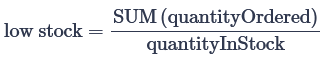

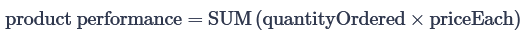

In [8]:
%%sql
--Low stock
SELECT productCode, 
       ROUND(SUM(quantityOrdered) * 1.0 / (SELECT quantityInStock
                                             FROM products p
                                            WHERE od.productCode = p.productCode), 2) AS low_stock
  FROM orderdetails od
 GROUP BY productCode
 ORDER BY low_stock
 LIMIT 10;
 

-- Product performance
SELECT productCode, 
       SUM(quantityOrdered * priceEach) AS prod_perf
  FROM orderdetails od
 GROUP BY productCode 
 ORDER BY prod_perf DESC
 LIMIT 10;
 
-- Priority Products for restocking
WITH 

low_stock_table AS (
SELECT productCode, 
       ROUND(SUM(quantityOrdered) * 1.0/(SELECT quantityInStock
                                           FROM products p
                                          WHERE od.productCode = p.productCode), 2) AS low_stock
  FROM orderdetails od
 GROUP BY productCode
 ORDER BY low_stock
 LIMIT 10
)

SELECT productCode, 
       SUM(quantityOrdered * priceEach) AS prod_perf
  FROM orderdetails od
 WHERE productCode IN (SELECT productCode
                         FROM low_stock_table)
 GROUP BY productCode 
 ORDER BY prod_perf DESC
 LIMIT 10;


 * sqlite:///stores.db
Done.
Done.
Done.


productCode,prod_perf
S12_2823,135767.03000000003
S18_3482,121890.6
S18_1984,119050.95
S18_2325,109992.01000000002
S18_1589,101778.13000000002
S18_2870,100770.12
S12_3380,98718.76000000001
S700_2466,89347.79999999999
S24_3432,87404.81000000001
S32_2206,33268.76


In [9]:
%%sql
WITH
--#Ten most popular products
get_lowstock AS(
SELECT productCode,
       --#Use low stock formula
       (SUM(od.quantityOrdered)*1.0)/ 
                       (SELECT quantityInStock
                          FROM products
                         WHERE od.productCode = productCode) AS low_stock
 FROM shipped_order_details od
GROUP BY productCode
ORDER BY low_stock DESC
LIMIT 10
)

SELECT products.productName AS Model_Name,
       products.quantityInStock AS Quantity_at_Hand,
       COUNT(*) AS No_of_Orders,
       SUM(shipped_order_details.quantityOrdered) AS Total_Quantity_Ordered,
       --#Use product performance formula
       ROUND(SUM(shipped_order_details.quantityOrdered*shipped_order_details.priceEach),2) AS Total_Sales,
       products.productLine AS Product_Line
  FROM shipped_order_details
  JOIN products
    ON products.productCode = shipped_order_details.productCode
 WHERE shipped_order_details.productCode IN (SELECT productCode
                                               FROM get_lowstock)
 GROUP BY products.productCode
 ORDER BY Total_Sales DESC
 --LIMIT 10;

 * sqlite:///stores.db
Done.


Model_Name,Quantity_at_Hand,No_of_Orders,Total_Quantity_Ordered,Total_Sales,Product_Line
1968 Ford Mustang,68,26,909,157749.08,Classic Cars
1928 Mercedes-Benz SSK,548,26,813,121946.96,Vintage Cars
1997 BMW F650 ST,178,26,920,81440.8,Motorcycles
2002 Yamaha YZR M1,600,27,992,73670.64,Motorcycles
1960 BSA Gold Star DBD34,15,28,1015,67193.49,Motorcycles
F/A 18 Hornet 1/72,551,24,872,63905.6,Planes
1928 Ford Phaeton Deluxe,136,25,846,52518.05,Vintage Cars
1996 Peterbilt 379 Stake Bed with Outrigger,814,26,895,52046.16,Trucks and Buses
1911 Ford Town Car,540,22,709,38730.32,Vintage Cars
Pont Yacht,414,22,770,38061.72,Ships


Clearly the **1960 BSA Gold Star DBD34** is the model which is most in demand and less in quantity. Its potential sales value is also quite promising. Besides the Ferrari model, there are a number of other models that demand ordering more of based on their potential sales value.

Another revealation from the above analysis is that the *Classic Cars* model seems to be the most popular model. We shall analyse this more as we go further.

# 5

## Customer Loyalty
**Identifying the Most Engaged and Least Engaged Customers**

The next task placed before us is to identify the customers who have been the most loyal. Vehicle Models has 122 customers. We shall define the **top 5 customers**  as those who have brought the most profit for the organisation through their shipped orders.

In [10]:
%%sql
CREATE VIEW customer_profit_report AS
SELECT shipped_orders.customerNumber AS customer_id,
       ROUND(SUM(shipped_order_details.quantityOrdered * (shipped_order_details.priceEach - products.buyPrice)),2) AS profit,
       COUNT(*) AS no_of_orders
  FROM shipped_orders
  JOIN shipped_order_details
    ON shipped_order_details.orderNumber=shipped_orders.orderNumber
  JOIN products
    ON shipped_order_details.productCode=products.productCode
 GROUP BY shipped_orders.customerNumber;

SELECT customers.contactLastName||", "||customers.contactFirstName AS Name,
       customers.city AS City,
       customers.country AS Country,
       customer_profit_report.profit AS Profit_Earned
  FROM customers
  JOIN customer_profit_report
    ON customers.customerNumber = customer_profit_report.customer_id
 WHERE customer_profit_report.customer_id IN (SELECT customer_id
                                                FROM customer_profit_report
                                               ORDER BY profit DESC
                                               LIMIT 5)
 ORDER BY customer_profit_report.profit DESC;

 * sqlite:///stores.db
Done.
Done.


Name,City,Country,Profit_Earned
"Freyre, Diego",Madrid,Spain,263439.51
"Nelson, Susan",San Rafael,USA,232494.29
"Young, Jeff",NYC,USA,72370.09
"Ferguson, Peter",Melbourne,Australia,70311.07
"Natividad, Eric",Singapore,Singapore,60477.38


Since we have the top 5 customers, we should also look at **5 of the customers who are least engaged** with the organization.

In [11]:
%%sql
SELECT customers.contactLastName||", "||customers.contactFirstName AS Name,
       customers.city AS City,
       customers.country AS Country,
       customer_profit_report.profit AS Profit
  FROM customers
  JOIN customer_profit_report
    ON customers.customerNumber = customer_profit_report.customer_id
 WHERE customer_profit_report.customer_id IN (SELECT customer_id
                                                FROM customer_profit_report
                                               ORDER BY profit ASC
                                               LIMIT 5)
 ORDER BY customer_profit_report.profit ASC;

 * sqlite:///stores.db
Done.


Name,City,Country,Profit
"Young, Mary",Glendale,USA,2610.87
"Taylor, Leslie",Brickhaven,USA,6586.02
"Mendel, Roland",Graz,Austria,8473.59
"Ricotti, Franco",Milan,Italy,9532.93
"Schmitt, Carine",Nantes,France,10063.8


# 6

## Show Me the Money...by Country!
**Analysing profits earned by Country**

Marketing is a costly affair. We need to identify markets where our strategy will yield the most customers. Besides attracting customers, we should be able to get high value customers to increase our profits. Since no parameters have been specfied, we will try to identify the potential markets from the existing customers and the sales they have made to date.

We shall focus on the following parameters:
- The number of customers in each country
- The percentage of profit contributed by each country towards the total time period for which we hold the sales data
- The profit generated by each customer of our current customer countries

This analysis should help to decide which countries to focus marketing on so as to increase profits.

In [13]:
%%sql
SELECT customers.country AS Country,
          COUNT(*) AS No_of_Customers,
          ROUND(SUM(customer_profit_report.profit),2) AS Profit_Earned,
          ROUND(SUM(customer_profit_report.profit)/COUNT(*),2) AS Profit_Per_Customer,
          ROUND((SUM(customer_profit_report.profit) * 100.0 / 
                                                            (SELECT SUM(profit)
                                                             FROM customer_profit_report)), 2) AS Profit_Percentage
     FROM customers
     JOIN customer_profit_report
       ON customers.customerNumber = customer_profit_report.customer_id
    GROUP BY customers.country
    ORDER BY Profit_Earned DESC;

 * sqlite:///stores.db
Done.


Country,No_of_Customers,Profit_Earned,Profit_Per_Customer,Profit_Percentage
USA,35,1214220.48,34692.01,34.32
France,12,397728.61,33144.05,11.24
Spain,5,376924.39,75384.88,10.66
Australia,5,201879.08,40375.82,5.71
New Zealand,4,165096.92,41274.23,4.67
UK,5,155313.0,31062.6,4.39
Italy,4,144459.86,36114.97,4.08
Finland,3,117239.33,39079.78,3.31
Singapore,2,101782.55,50891.28,2.88
Canada,3,78858.78,26286.26,2.23
